In [1]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
EPS = 1e-15
MAX_LOGSTD = 10

class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj



class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :oenbj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss


    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import roc_auc_score, average_precision_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        
        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)



class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(VGAE, self).__init__(encoder, decoder)

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def kl_loss(self, mu=None, logstd=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logstd (Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))

In [2]:
import torch
from torch.autograd.grad_mode import F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE

import scipy.sparse as sp
import numpy as np
import networkx as nx

class SimuData():
    """Simulate graph data"""
    def __init__(self, p=0.5, n_node=10, n_graph=30):
        self.n_node = n_node
        self.n_graph = n_graph
        self.p = p

    def simu_adj_wgh(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)

            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.rand(5,5)

            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]

            A[:5,:5] = W
            adj_list.append(A)  

        return adj_list

    def simu_adj_diag(self):
        adj_list = []

        for i in range(self.n_graph):
            A = torch.eye(self.n_node)
            adj_list.append(A)  

        return adj_list

    def simu_adj_m(self):
        """generating adjacency matrix"""
        adj_wgh = self.simu_adj_wgh()
        #adj_wgh = self.simu_adj_diag()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>=1-self.p] = 1
            adj[adj<1-self.p] = 0
            for i in range(adj.shape[0]):
                adj[i, i] = 0
            adj_m_list.append(adj)    
        return adj_m_list

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.simu_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)

        return dataset

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) 
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


transform = T.Compose([
            T.NormalizeFeatures(),
            T.RandomLinkSplit(num_val=0, num_test=0, is_undirected=True,
                            split_labels=True, add_negative_train_samples=False),])

In [ ]:
simu_graph = SimuData(n_graph=30)
dataset = simu_graph.graph_dataset()
n_node = simu_graph.n_node

out_channels = 2
num_features = n_node

model = VGAE(Encoder(num_features, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 100000

for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()
    
    for i in range(len(dataset)):
        train_data, val_data, test_data = transform(dataset[i])
        z = model.encode(train_data.x, train_data.edge_index)
        loss = model.recon_loss(z, train_data.pos_edge_label_index)
        loss = loss + (1 /num_features) * model.kl_loss()
        loss_total += loss

    loss_avg = loss_total/len(dataset)
    loss_avg.backward()
    optimizer.step()
    print(str(epoch)+str(loss_avg))

In [28]:
os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
os.getcwd()
PATH = 'vgae_model.pth'
torch.save(model, PATH)

model = torch.load(PATH)
model.eval()

VGAE(
  (encoder): Encoder(
    (conv1): GCNConv(10, 4)
    (conv_mu): GCNConv(4, 2)
    (conv_logstd): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)

In [29]:
# get mu and logstd 

mu_list_in_data = []
logstd_list_in_data = []
for i in range(len(dataset)):
    train_data = dataset[i]
    mu, logstd = Encoder(n_node, out_channels)(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))
    logstd_list_in_data.append(np.asarray(logstd.detach()))

mu_list_reshape = []
logstd_list_reshape = []
n = len(dataset)
for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))
    logstd_list_reshape.append(logstd_list_in_data[i].reshape((out_channels * n_node)))

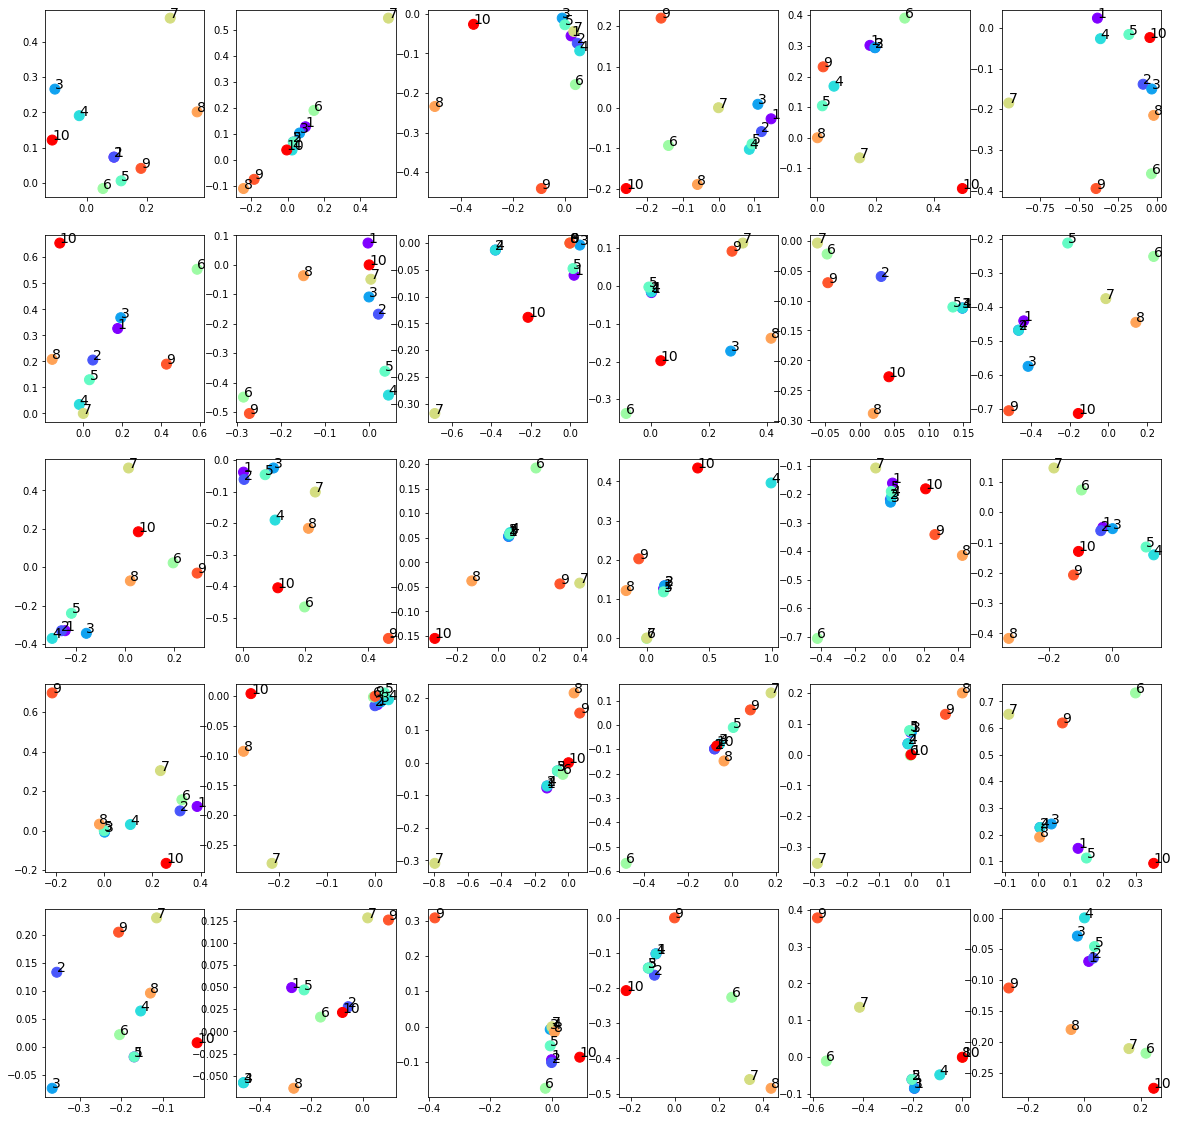

In [33]:
import matplotlib.pyplot as plt
def plot_mu_graph(mu):
    
    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)
    
    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

        
plt.subplots(figsize=(20,20))

for graph_i in range(30):
    plt.subplot(5, 6, graph_i+1)
    plot_mu_graph(mu_list_in_data[graph_i])

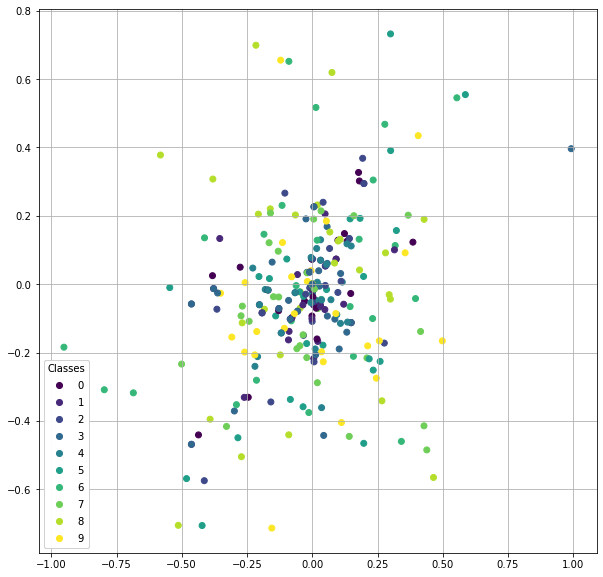

In [39]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
def plot_scatter_for_mu(mu_list):
    column_names = ["x", "y"]
    mu_for_plot = pd.DataFrame(columns = column_names, data=np.vstack(mu_list))
    mu_for_plot["label"] = list(range(10))*len(mu_list)
    x = mu_for_plot["x"]
    y = mu_for_plot["y"]
    c = mu_for_plot["label"]
    fig, ax = plt.subplots(figsize=(10,10))
    scatter = ax.scatter(x, y, c=c)

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend1)

    plt.grid()
    plt.show()

plot_scatter_for_mu(mu_list_in_data)

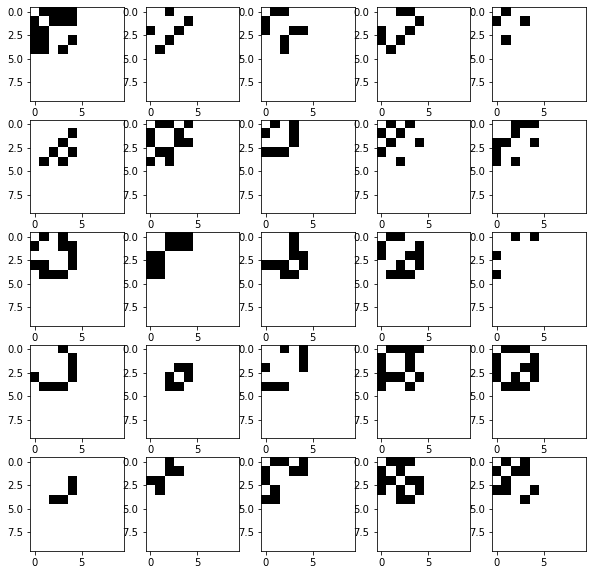

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 5, figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(simu_graph.simu_adj_m()[i], cmap="Greys")

In [41]:
import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
data_logstd = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]
    data_logstd[i, :] = logstd_list_reshape[i]

In [42]:
from sklearn.mixture import GaussianMixture
gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1

C:\Users\Ji Qi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [43]:
means_normal = gm_mu.means_
cov_normal = gm_mu.covariances_
means_normal = np.asarray(means_normal.tolist()[0])
cov_normal = np.asarray(cov_normal.tolist()[0])*0.01

In [44]:
#construct edge index
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

In [52]:
print(means_normal.reshape((n_node,out_channels)))
print(cov_normal)

[[-0.01339133 -0.01161491]
 [-0.03319702 -0.02943349]
 [-0.0205788  -0.02528773]
 [-0.02234722 -0.04344224]
 [-0.01145429 -0.03616821]
 [ 0.0156224  -0.05876701]
 [-0.03305156  0.01553821]
 [-0.00932674 -0.0843269 ]
 [-0.02763516  0.00549472]
 [-0.00044699 -0.06068539]]
[[ 2.91818353e-04  1.60499754e-04  2.16081858e-04  1.68738740e-04
   2.02553553e-04  2.09704712e-04  2.71394289e-04  1.48749801e-04
   1.50435180e-04  7.02626737e-05  1.31672976e-04  1.95080240e-04
   2.31904503e-04  1.14324599e-04 -1.99410606e-05  1.01731634e-04
   1.26437544e-04  2.51133278e-04  1.08231122e-04  9.80957154e-05]
 [ 1.60499754e-04  2.28830130e-04  1.61124167e-04  2.10877854e-04
   1.23290847e-04  2.45855999e-04  1.47195796e-04  1.82760813e-04
   7.43734528e-05  1.15780392e-04  1.12824448e-04  2.54500574e-04
   6.98664521e-05  9.46385570e-05 -8.24886709e-05  1.72548593e-04
   9.29483902e-05  2.18370516e-04  9.15436566e-05  2.00767405e-04]
 [ 2.16081858e-04  1.61124167e-04  2.64760931e-04  1.33551291e-04
 

In [45]:
def sample_adj_mat(filter_value=0.75, filter_eye=True):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    adj_mat[adj_mat < filter_value] = 0
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__

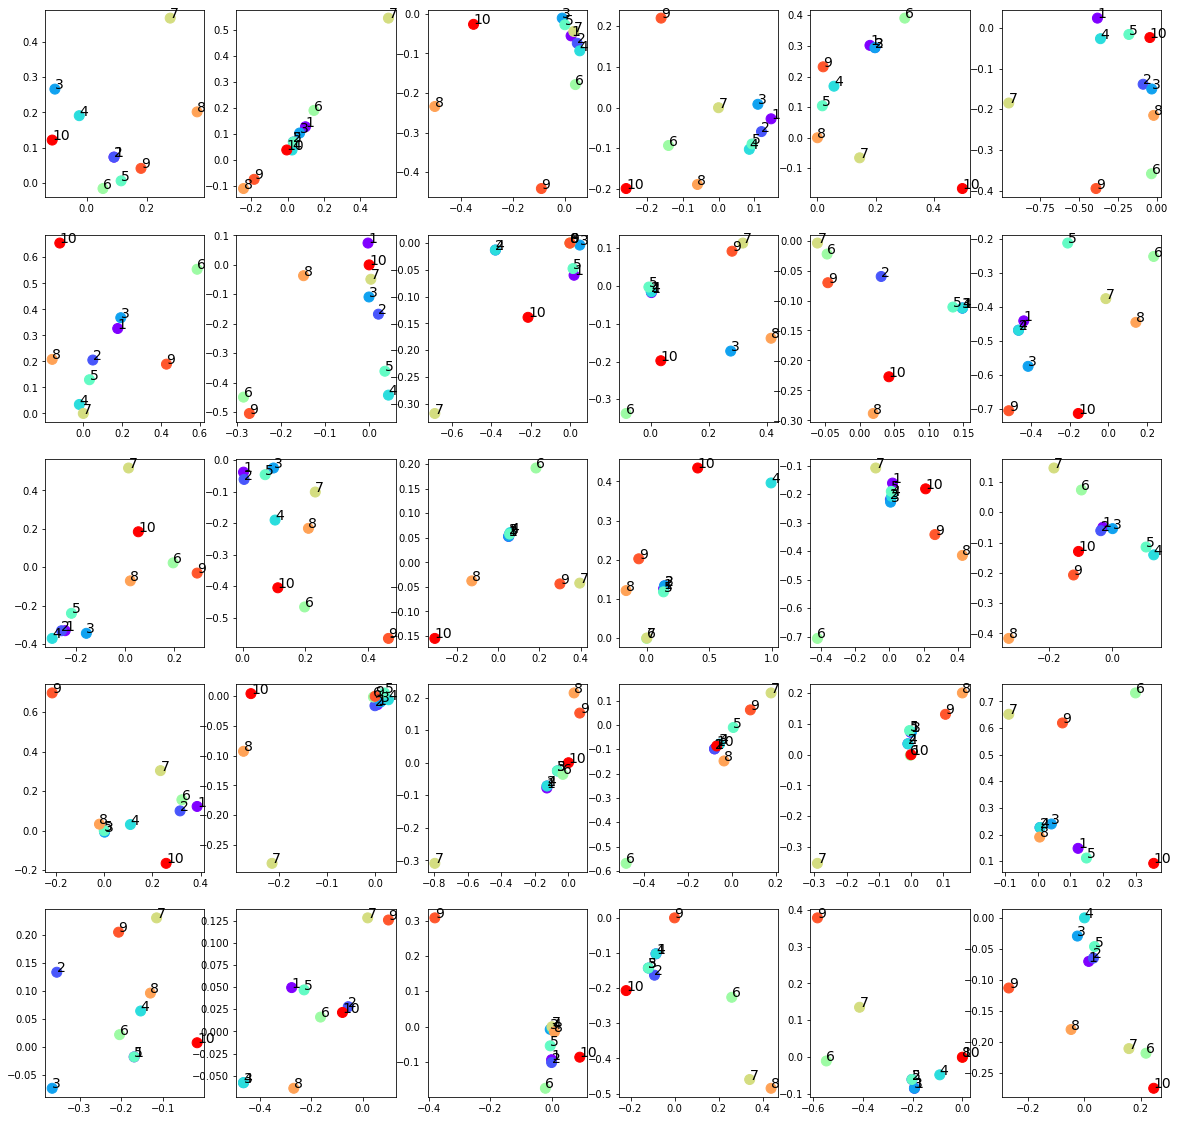

In [46]:
import matplotlib.pyplot as plt
def plot_mu_graph(mu):
    
    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)
    
    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

        
plt.subplots(figsize=(20,20))

for graph_i in range(30):
    plt.subplot(5, 6, graph_i+1)
    plot_mu_graph(mu_list_in_data[graph_i])

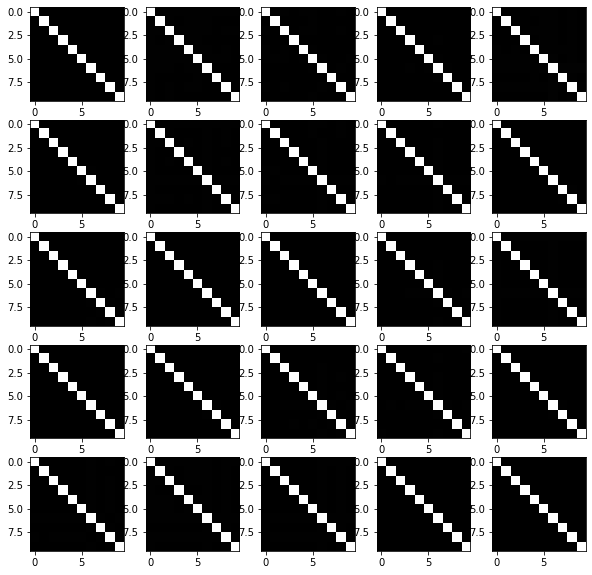

In [47]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 5, figsize=(10,10))
adj_mat_list = []
mu_list = []
for i in range(25):
    plt.subplot(5, 5, i+1)
    adj_mat, mu_sample = sample_adj_mat(filter_value=0)
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
    plt.imshow(adj_mat, cmap="Greys")

In [ ]:
adj_mat.sum(axis=1)

array([4.50018903, 4.5005593 , 4.50020204, 4.50030588, 4.50029251,
       4.50088566, 4.50018091, 4.50109394, 4.50045488, 4.5003475 ])

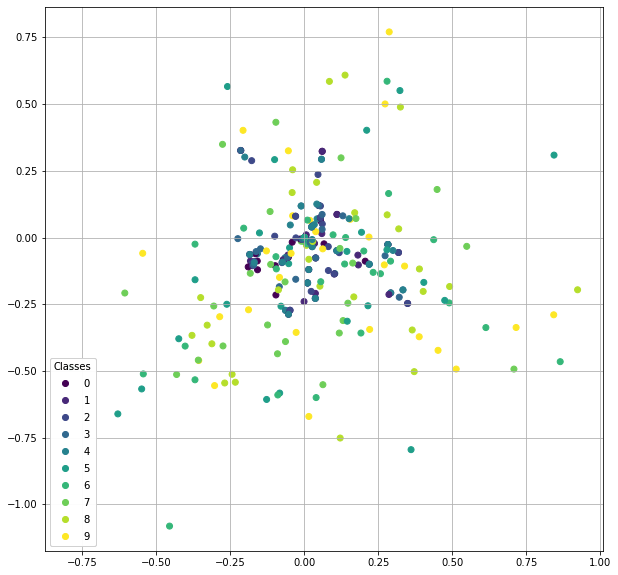

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
def plot_scatter_for_mu(mu_list):
    column_names = ["x", "y"]
    mu_for_plot = pd.DataFrame(columns = column_names, data=np.vstack(mu_list))
    mu_for_plot["label"] = list(range(10))*30
    x = mu_for_plot["x"]
    y = mu_for_plot["y"]
    c = mu_for_plot["label"]
    fig, ax = plt.subplots(figsize=(10,10))
    scatter = ax.scatter(x, y, c=c)

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend1)

    plt.grid()
    plt.show()

plot_scatter_for_mu(mu_list_in_data)

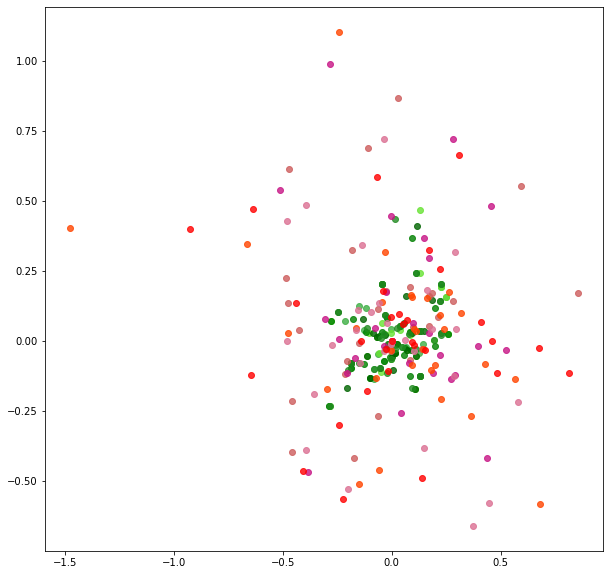

In [ ]:
simu_graph = SimuData(n_graph=30)
dataset = simu_graph.graph_dataset()
n_node = simu_graph.n_node

colors = ['#3DAE43', '#67E332','#008000', '#006400', '#228B22',
          '#CD5C5C','#C71585', '#FF4500', '#DB7093', '#FF0000']
mu_list = []
logstd_list = []
for i in range(len(dataset)):
    train_data = dataset[i]
    mu, logstd = Encoder(n_node, out_channels)(train_data.x, train_data.edge_index)
    mu_list.append(np.asarray(mu.detach()))
    logstd_list.append(np.asarray(logstd.detach()))

plt.figure(figsize=(10,10))
for node_i in range(n_node):
    
    node_mu = np.empty((0, 2))
    for graph_i in range(len(mu_list)):
    
        node_mu = np.vstack((node_mu, mu_list[graph_i][node_i, :]))
    
    plt.scatter(node_mu[:,0],node_mu[:,1], c=colors[node_i],alpha=0.8)

plt.show()

In [55]:
def compute_centrality(mat):
    return np.sum(mat, axis=1)

adj, mu = sample_adj_mat(filter_value=0)
compute_centrality(adj)

array([4.51204743, 4.51654568, 4.51731996, 4.51861309, 4.51407376,
       4.52914386, 4.50782192, 4.52554541, 4.51731951, 4.52264035])